In [1]:
from libra.count_profiler import *
from libra.util import load_idx_split
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def plot(graph_name: str, data_dir: str, is_pruned: bool, partype: str, mode: str):
    prof = CountProfiler(None, None, None)
    cnt_dir = "cnt"
    in_dir = os.path.join(data_dir, graph_name)
    train_idx, test_idx, valid_idx = load_idx_split(in_dir, is32=True)
    prefix = "pruned_" if is_pruned else ""
    prof_path = os.path.join(cnt_dir, f"{prefix}{graph_name}_{partype}.pt")
    prof.load(prof_path)

    src, dst, loc, crs = prof.get_cnts(mode, 0, 3)
    par_map = prof.get_map(mode)
    train_map = par_map[train_idx]
    train_dist = torch.bincount(train_map)


    def toTensor(row):
        return torch.Tensor(row).type(torch.int)

    tcrs = toTensor(crs) 
    tloc = toTensor(loc)
    tdst = toTensor(dst)
    tsrc = toTensor(src)
    tsum = tcrs + tloc
    crs_workloads = torch.div(tcrs, torch.sum(tsum, dim=1).reshape(-1, 1))
    loc_workloads = torch.div(tloc, torch.sum(tsum, dim=1).reshape(-1, 1))
    edge_workloads = torch.div(tsum, torch.sum(tsum, dim=1).reshape(-1, 1))
    src_workloads = torch.div(tsrc, torch.sum(tsrc, dim=1).reshape(-1, 1))
    dst_workloads = torch.div(tdst, torch.sum(tdst, dim=1).reshape(-1, 1))

    print("train_idx_workload: ",  train_dist, train_dist / torch.sum(train_dist))
    print("total_edge_workload:",  torch.sum(tsum, dim=0), torch.sum(tsum, dim=0) / torch.sum(tsum))
    print("total_cross_edges:  ",  torch.sum(tcrs, dim=0), torch.sum(tcrs, dim=0) / torch.sum(tsum, dim=0))
    print("total_local_edges:  ",  torch.sum(tloc, dim=0), torch.sum(tloc, dim=0) / torch.sum(tsum, dim=0))

    tdist = (train_dist / torch.sum(train_dist)).to("cpu").numpy()
    xticks = [f"P{i}" for i in range(4)]
    cnts = {
        "Local Edges": torch.sum(tloc, dim=0).numpy(),
        "Cross Edges": torch.sum(tcrs, dim=0).numpy(),
    }
    width = 0.5

    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(4)
    font = {'size' : 18} 
    plt.rc('font', **font)
    for label, cnt in cnts.items():
        p = ax.bar(xticks, cnt, width, label=label, bottom=bottom)
        bottom += cnt

    ax2 = ax.twinx()
    ax2.plot(xticks, tdist, label="target distribution", color="red")
    ax2.set_ylabel("Percentage")
    ax2.set_ylim(ymin=0, ymax=0.5)
    
    # if partype != "node":
    #     ax.set_ylim(ymax=1e9)
        
    ax.set_title(f"{prefix}{graph_name}-{partype}-{mode}")
    ax.set_ylabel("Number of Edges")
    ax.legend()
    ax2.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"figs/{prefix}{graph_name}-{partype}-{mode}.png")
    plt.show()
    
    
    tmax, tmax_idx = torch.max(tsum, dim=1)
    x = tmax / torch.sum(tsum, dim=1) * 4
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.ecdf(x)
    ax.set_title("Workload Inbalance of Mini-Batches")
    ax.set_ylabel("CDF")
    ax.set_xlabel("# Max Edges / Average Edges In the Partitions")
    plt.tight_layout()
    plt.savefig(f"figs/{prefix}{graph_name}-{partype}-{mode}_minibatch.png")
    plt.show()

train_idx_workload:  tensor([49037, 49460, 48215, 49903], device='cuda:0') tensor([0.2494, 0.2516, 0.2452, 0.2538], device='cuda:0')
total_edge_workload: tensor([229321685, 229658017, 235159164, 261332076]) tensor([0.2400, 0.2404, 0.2461, 0.2735])
total_cross_edges:   tensor([13479147, 13975546, 18456752, 27020564]) tensor([0.0588, 0.0609, 0.0785, 0.1034])
total_local_edges:   tensor([215842538, 215682471, 216702412, 234311512]) tensor([0.9412, 0.9391, 0.9215, 0.8966])


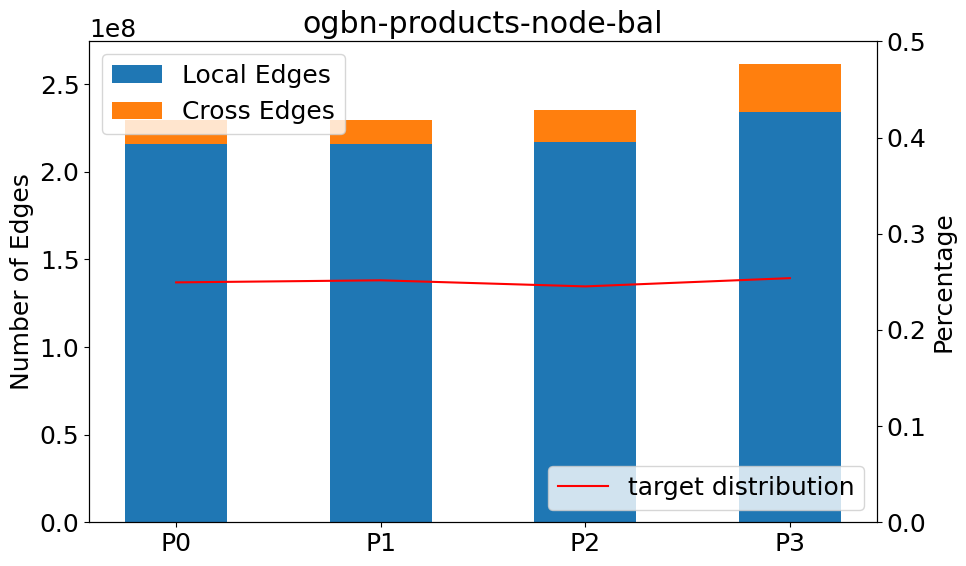

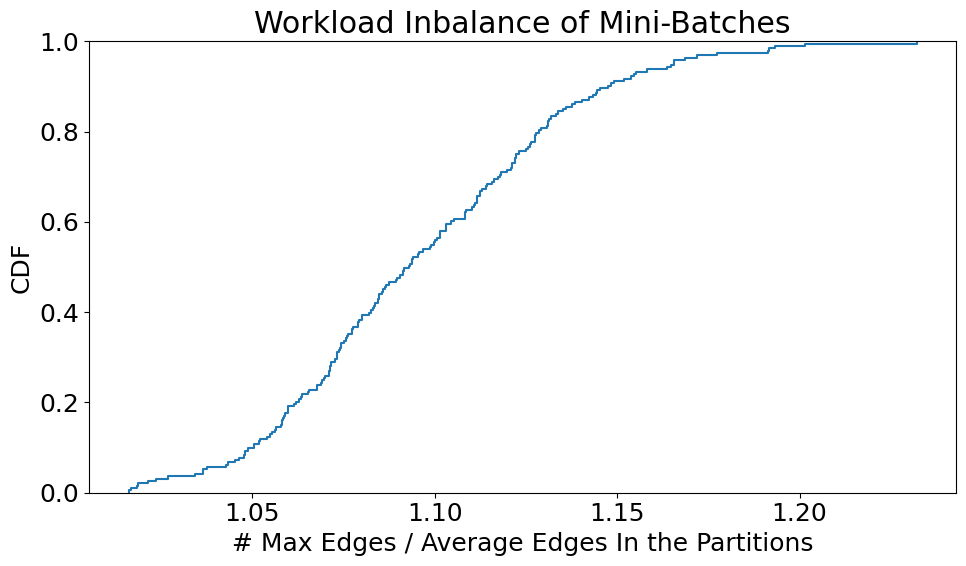

train_idx_workload:  tensor([59754, 25832, 55383, 55646], device='cuda:0') tensor([0.3039, 0.1314, 0.2817, 0.2830], device='cuda:0')
total_edge_workload: tensor([286054938, 131965524, 263650850, 273799630]) tensor([0.2994, 0.1381, 0.2759, 0.2866])
total_cross_edges:   tensor([22523203, 10502259, 14898077, 31530370]) tensor([0.0787, 0.0796, 0.0565, 0.1152])
total_local_edges:   tensor([263531735, 121463265, 248752773, 242269260]) tensor([0.9213, 0.9204, 0.9435, 0.8848])


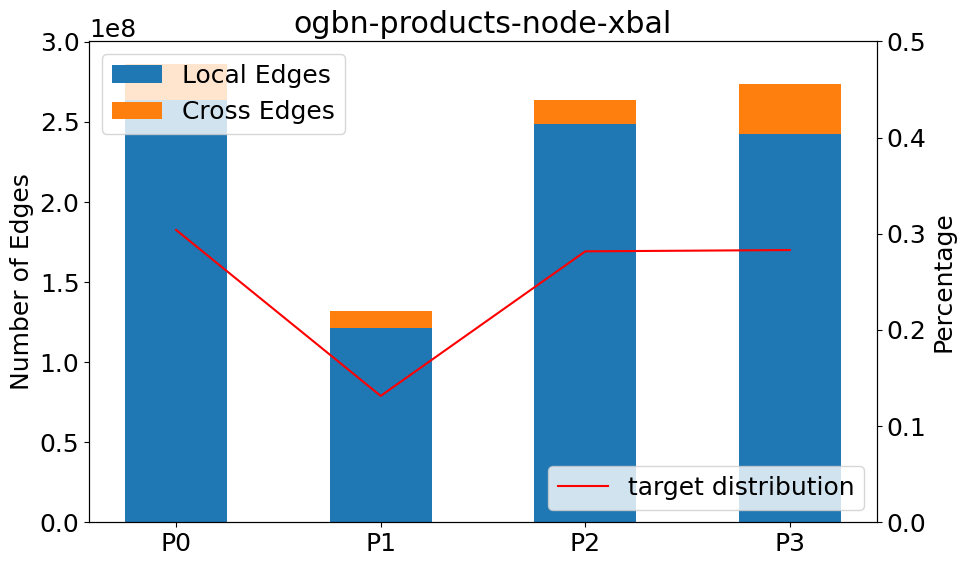

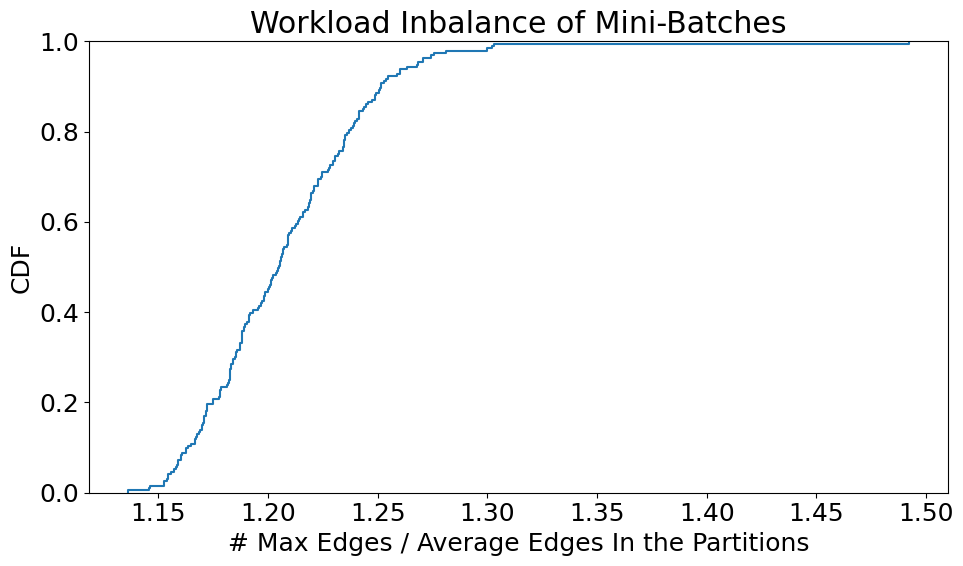

train_idx_workload:  tensor([50289, 50933, 50754, 44639], device='cuda:0') tensor([0.2558, 0.2590, 0.2581, 0.2270], device='cuda:0')
total_edge_workload: tensor([239266895, 251401527, 244192205, 220420152]) tensor([0.2505, 0.2632, 0.2556, 0.2307])
total_cross_edges:   tensor([25011448, 27352639, 18607975, 28030926]) tensor([0.1045, 0.1088, 0.0762, 0.1272])
total_local_edges:   tensor([214255447, 224048888, 225584230, 192389226]) tensor([0.8955, 0.8912, 0.9238, 0.8728])


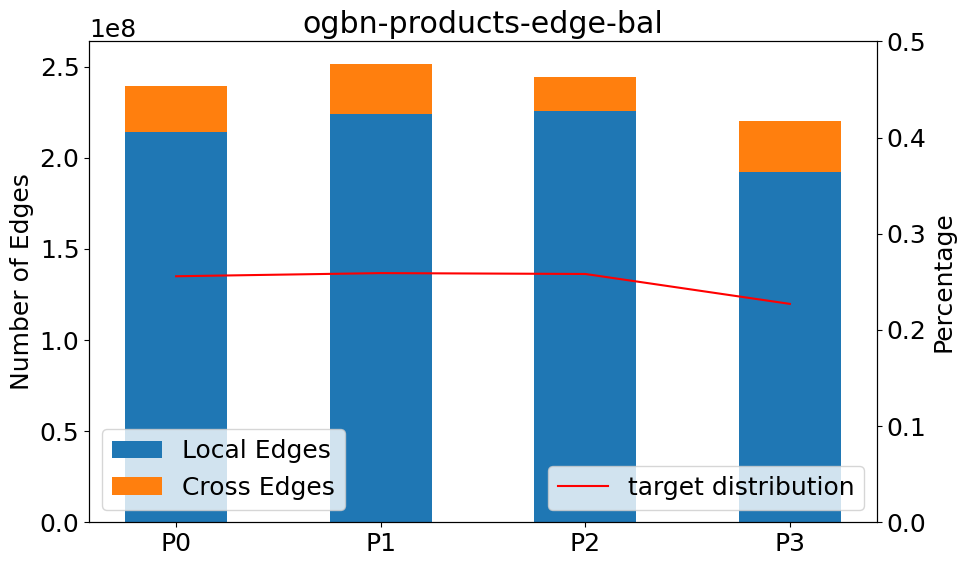

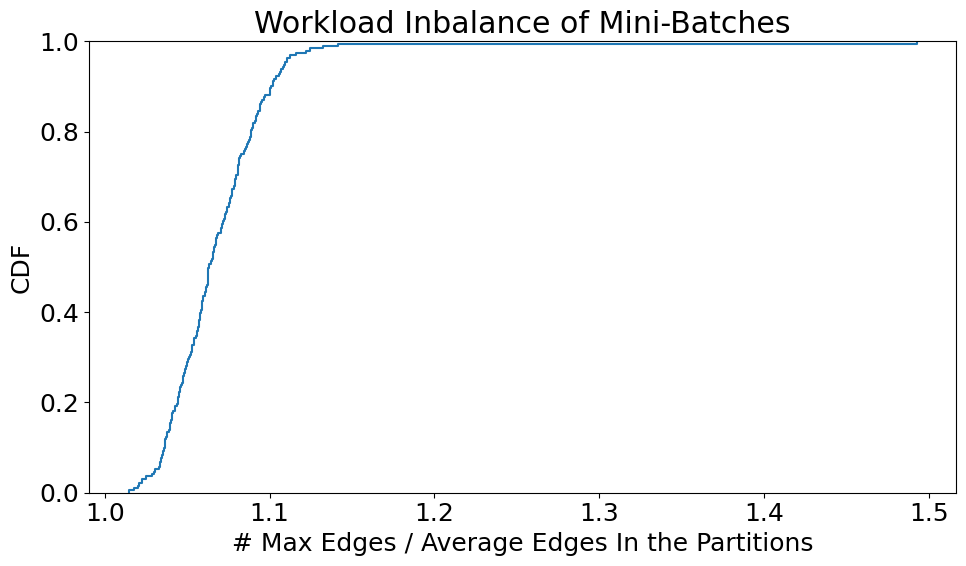

train_idx_workload:  tensor([57471, 53634, 53189, 32321], device='cuda:0') tensor([0.2923, 0.2728, 0.2705, 0.1644], device='cuda:0')
total_edge_workload: tensor([274389427, 257409740, 258746177, 164735435]) tensor([0.2872, 0.2695, 0.2709, 0.1724])
total_cross_edges:   tensor([15582032, 25337215, 25185667, 17392007]) tensor([0.0568, 0.0984, 0.0973, 0.1056])
total_local_edges:   tensor([258807395, 232072525, 233560510, 147343428]) tensor([0.9432, 0.9016, 0.9027, 0.8944])


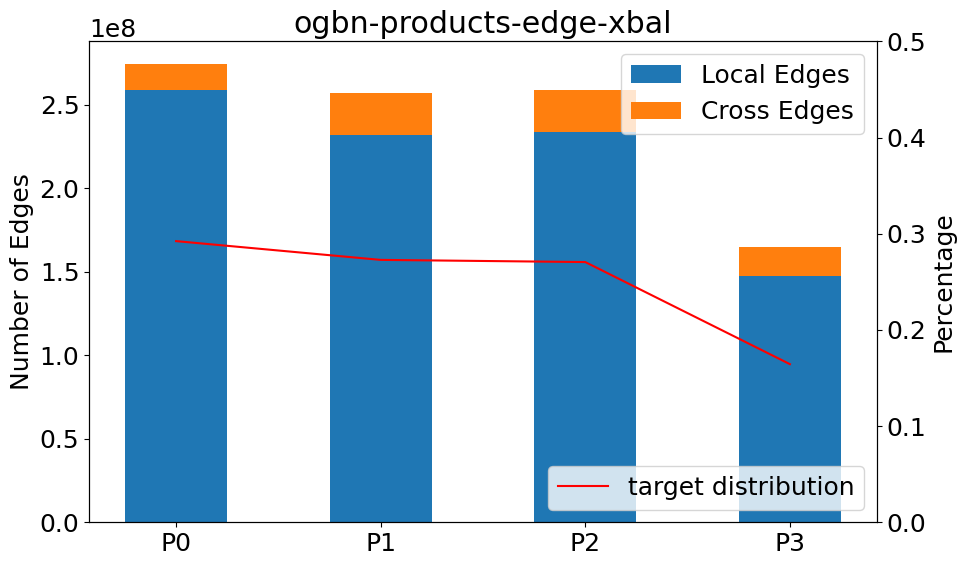

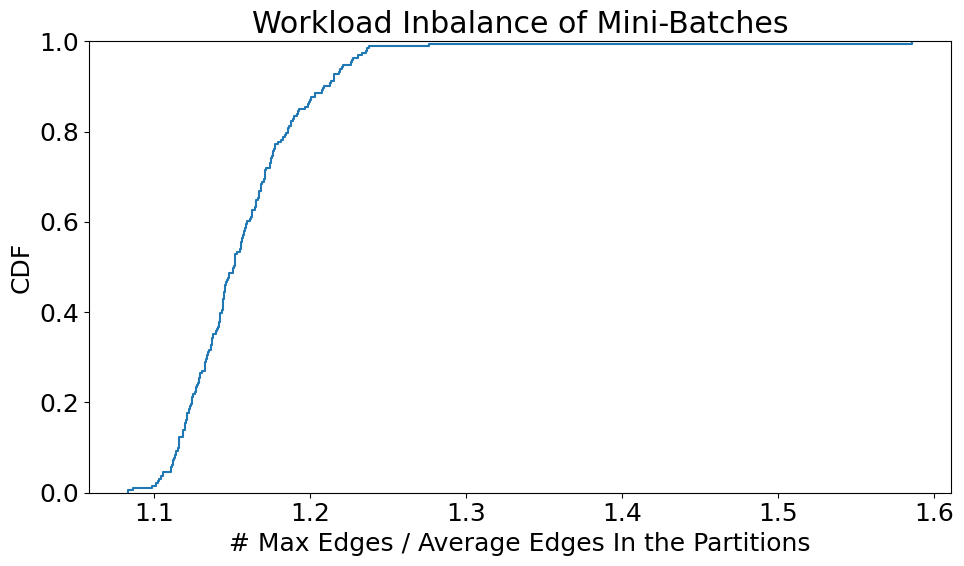

train_idx_workload:  tensor([49242, 49351, 47449, 50573], device='cuda:0') tensor([0.2504, 0.2510, 0.2413, 0.2572], device='cuda:0')
total_edge_workload: tensor([245993543, 240040394, 225364725, 243438762]) tensor([0.2576, 0.2514, 0.2360, 0.2550])
total_cross_edges:   tensor([25601257, 16985580, 18358340, 24901368]) tensor([0.1041, 0.0708, 0.0815, 0.1023])
total_local_edges:   tensor([220392286, 223054814, 207006385, 218537394]) tensor([0.8959, 0.9292, 0.9185, 0.8977])


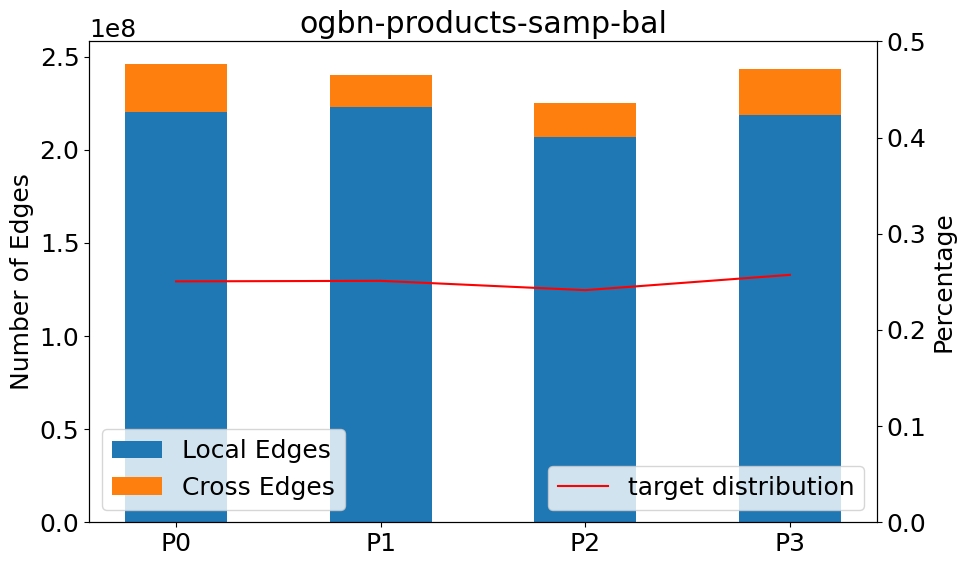

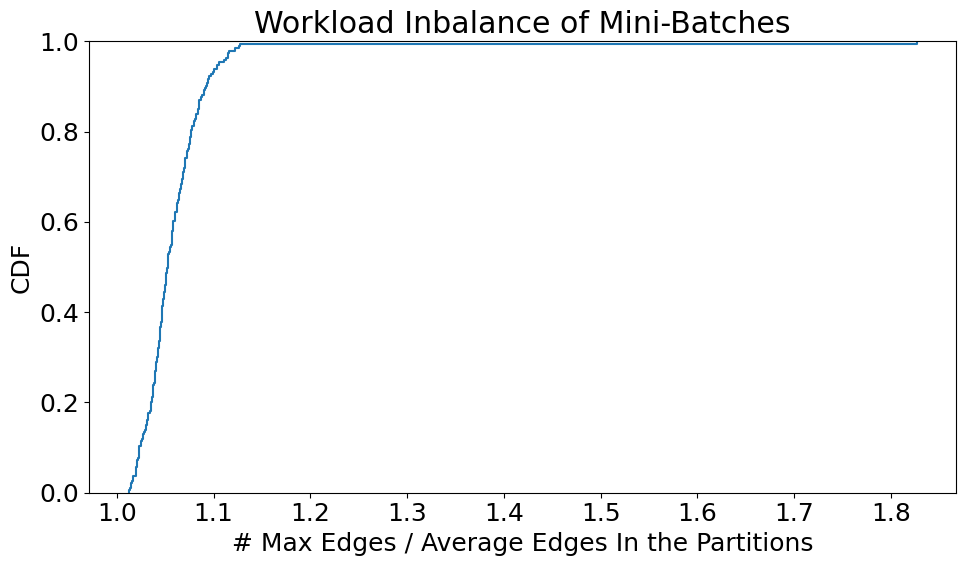

train_idx_workload:  tensor([49532, 45515, 49121, 52447], device='cuda:0') tensor([0.2519, 0.2315, 0.2498, 0.2667], device='cuda:0')
total_edge_workload: tensor([239431751, 241366945, 229419734, 244618994]) tensor([0.2508, 0.2528, 0.2403, 0.2562])
total_cross_edges:   tensor([15972198, 28168389, 19494154, 18706869]) tensor([0.0667, 0.1167, 0.0850, 0.0765])
total_local_edges:   tensor([223459553, 213198556, 209925580, 225912125]) tensor([0.9333, 0.8833, 0.9150, 0.9235])


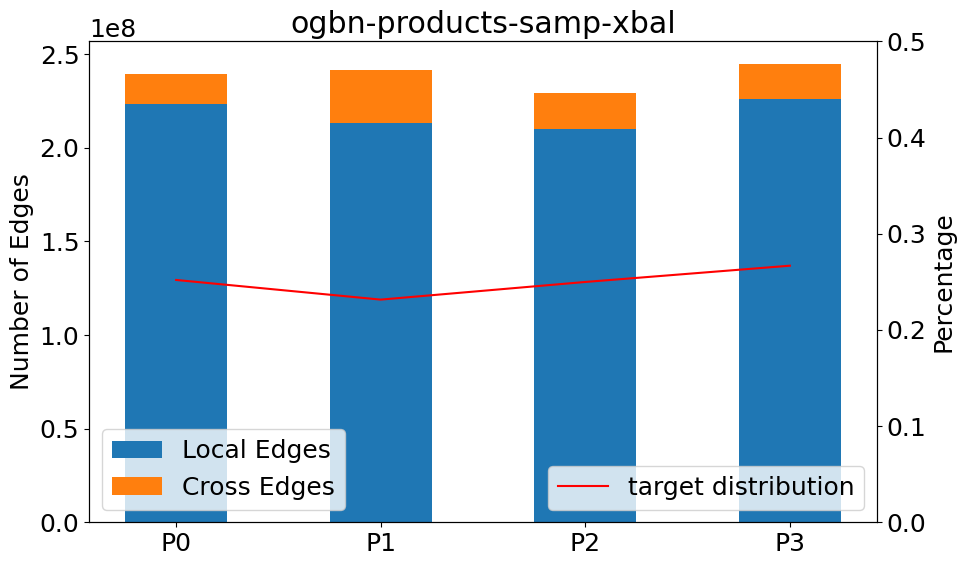

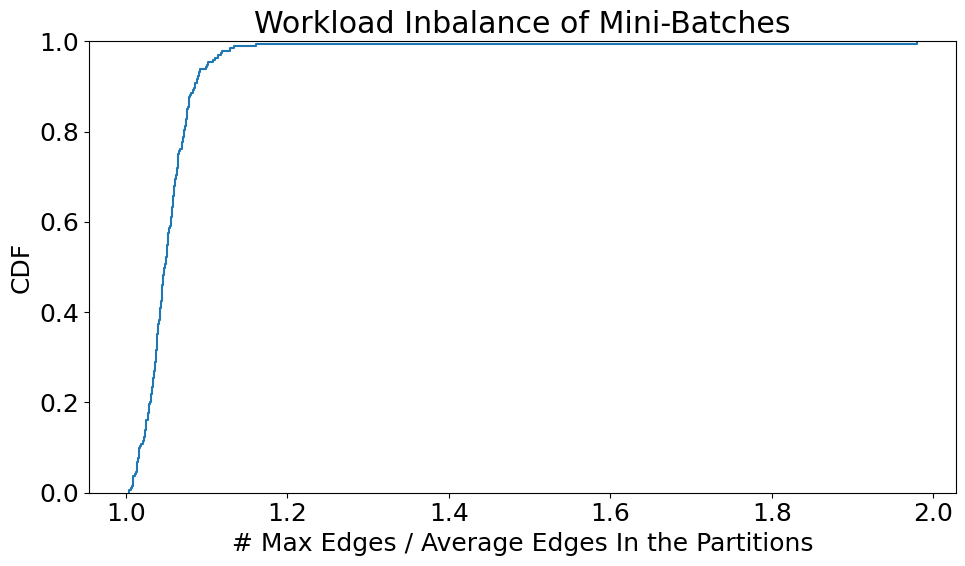

train_idx_workload:  tensor([311685, 311686, 306173, 277635], device='cuda:0') tensor([0.2582, 0.2582, 0.2536, 0.2300], device='cuda:0')
total_edge_workload: tensor([215775680, 161179187,  48941007, 230403370]) tensor([0.3288, 0.2456, 0.0746, 0.3511])
total_cross_edges:   tensor([27737771, 11593021,  7887689, 21458294]) tensor([0.1285, 0.0719, 0.1612, 0.0931])
total_local_edges:   tensor([188037909, 149586166,  41053318, 208945076]) tensor([0.8715, 0.9281, 0.8388, 0.9069])


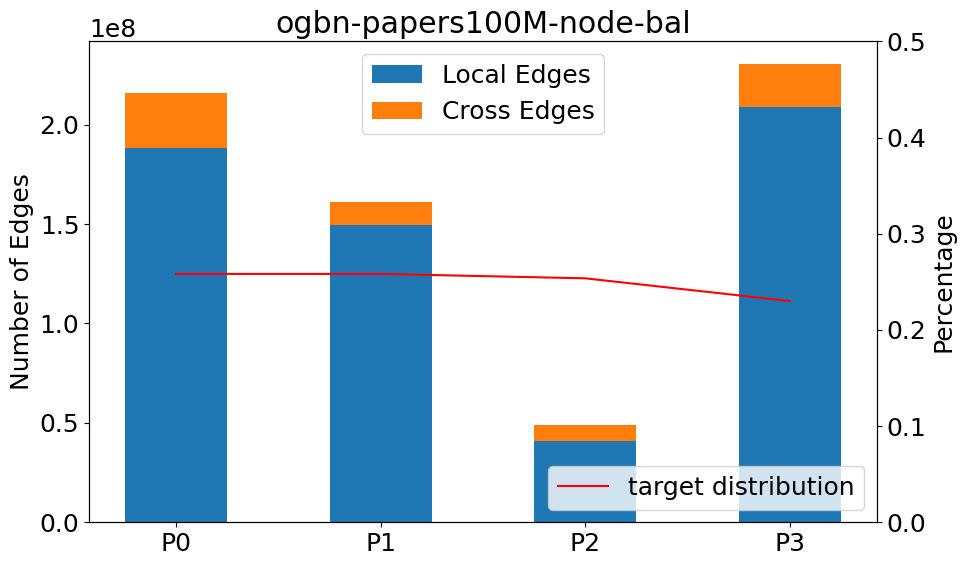

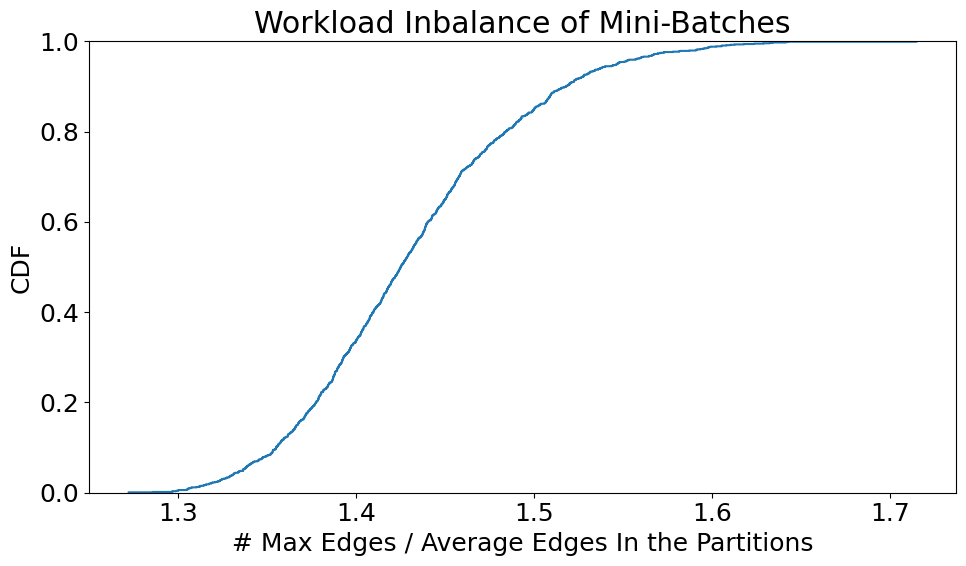

train_idx_workload:  tensor([954046, 106055, 136535,  10543], device='cuda:0') tensor([0.7903, 0.0879, 0.1131, 0.0087], device='cuda:0')
total_edge_workload: tensor([606105049,  12159354,  30017388,   8017453]) tensor([0.9235, 0.0185, 0.0457, 0.0122])
total_cross_edges:   tensor([6591305, 1342854, 2909198, 1259431]) tensor([0.0109, 0.1104, 0.0969, 0.1571])
total_local_edges:   tensor([599513744,  10816500,  27108190,   6758022]) tensor([0.9891, 0.8896, 0.9031, 0.8429])


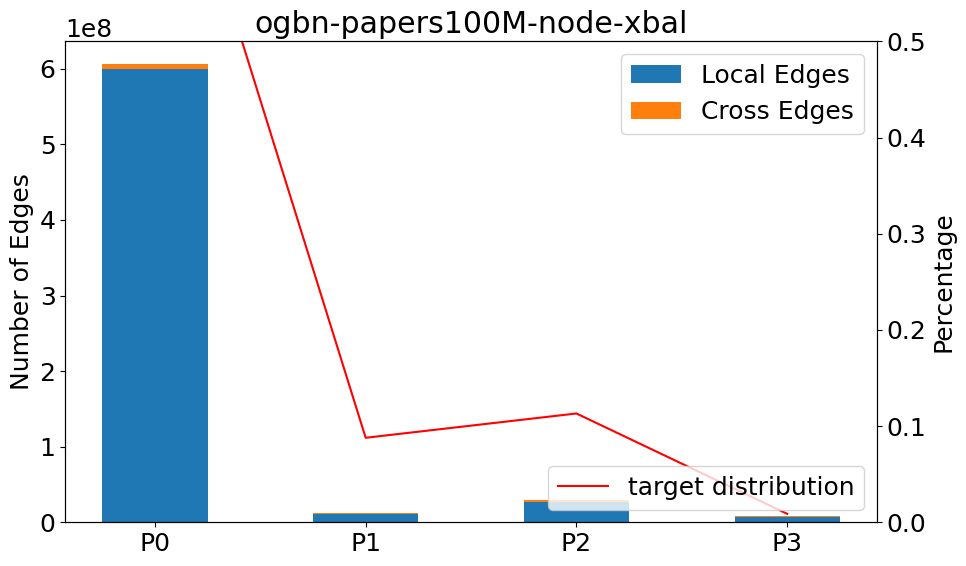

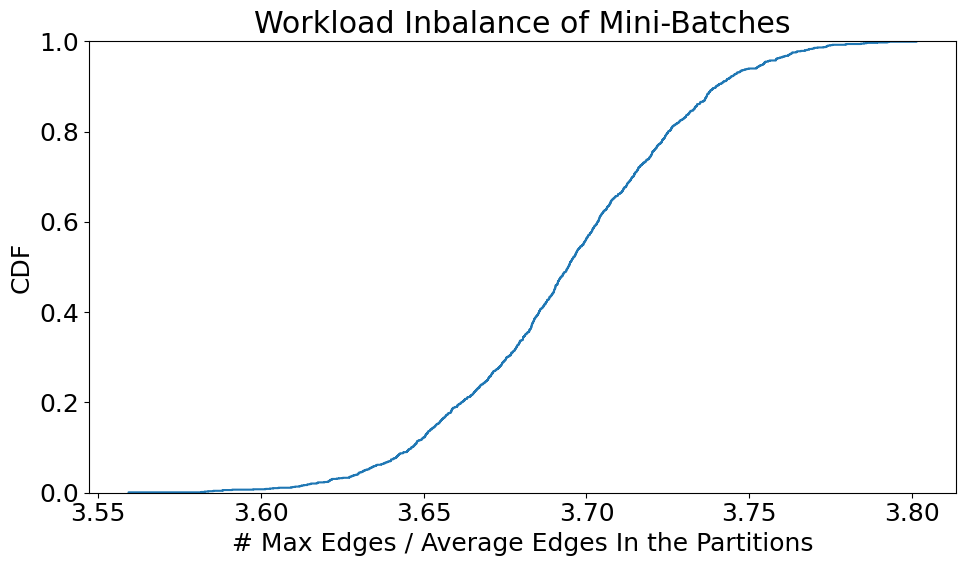

train_idx_workload:  tensor([307775, 305044, 314913, 279447], device='cuda:0') tensor([0.2550, 0.2527, 0.2609, 0.2315], device='cuda:0')
total_edge_workload: tensor([168478094, 152774251, 186915324, 148039900]) tensor([0.2567, 0.2328, 0.2848, 0.2256])
total_cross_edges:   tensor([28498383, 24045382, 34280898, 11603986]) tensor([0.1692, 0.1574, 0.1834, 0.0784])
total_local_edges:   tensor([139979711, 128728869, 152634426, 136435914]) tensor([0.8308, 0.8426, 0.8166, 0.9216])


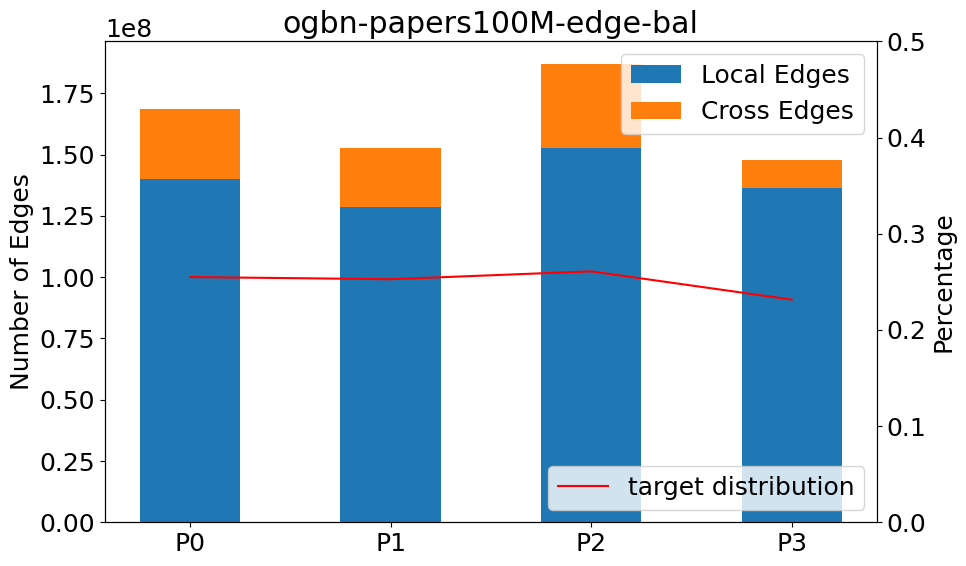

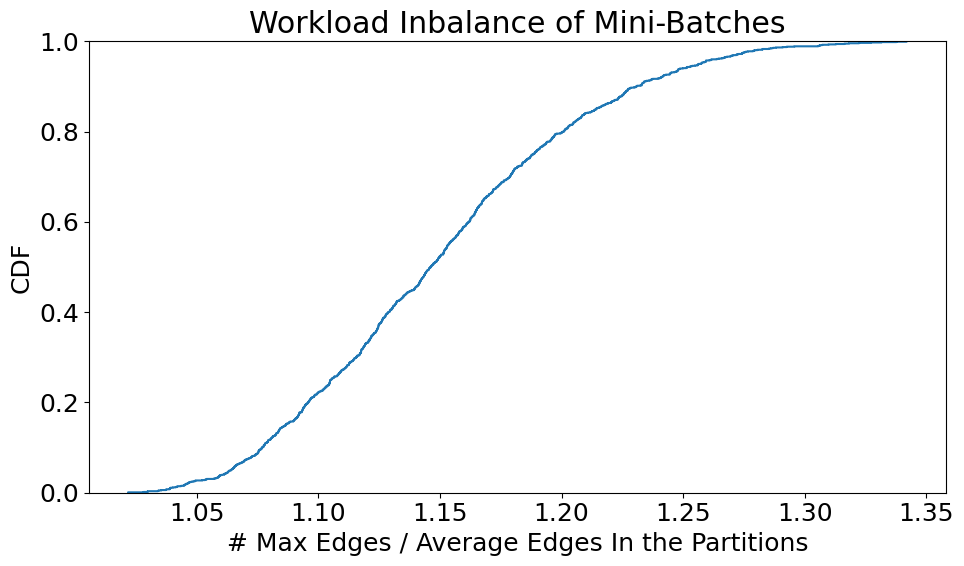

train_idx_workload:  tensor([202310,   1290, 878483, 125096], device='cuda:0') tensor([0.1676, 0.0011, 0.7277, 0.1036], device='cuda:0')
total_edge_workload: tensor([ 40441800,   1569675, 530254816,  83941278]) tensor([0.0616, 0.0024, 0.8081, 0.1279])
total_cross_edges:   tensor([2702852,  337385, 9864087, 8345655]) tensor([0.0668, 0.2149, 0.0186, 0.0994])
total_local_edges:   tensor([ 37738948,   1232290, 520390729,  75595623]) tensor([0.9332, 0.7851, 0.9814, 0.9006])


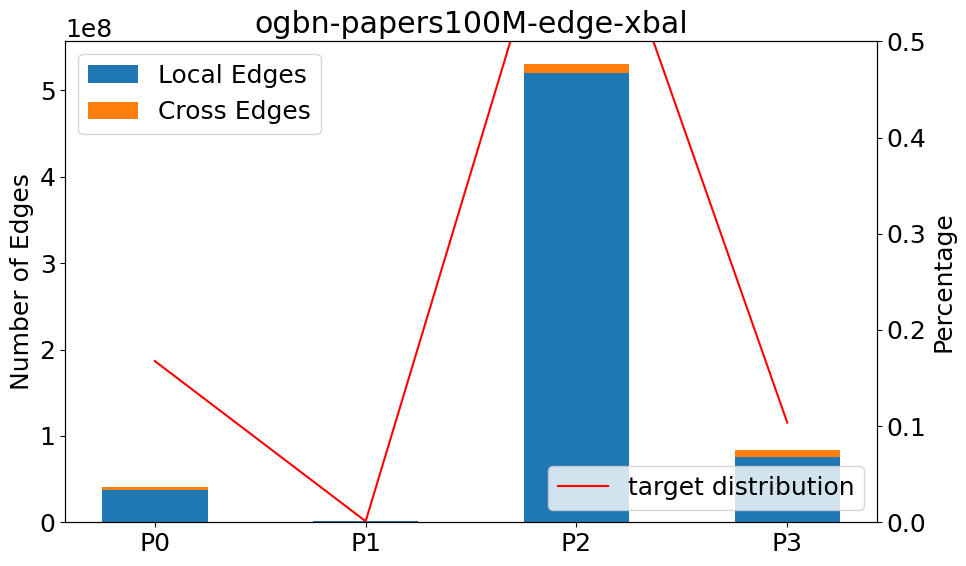

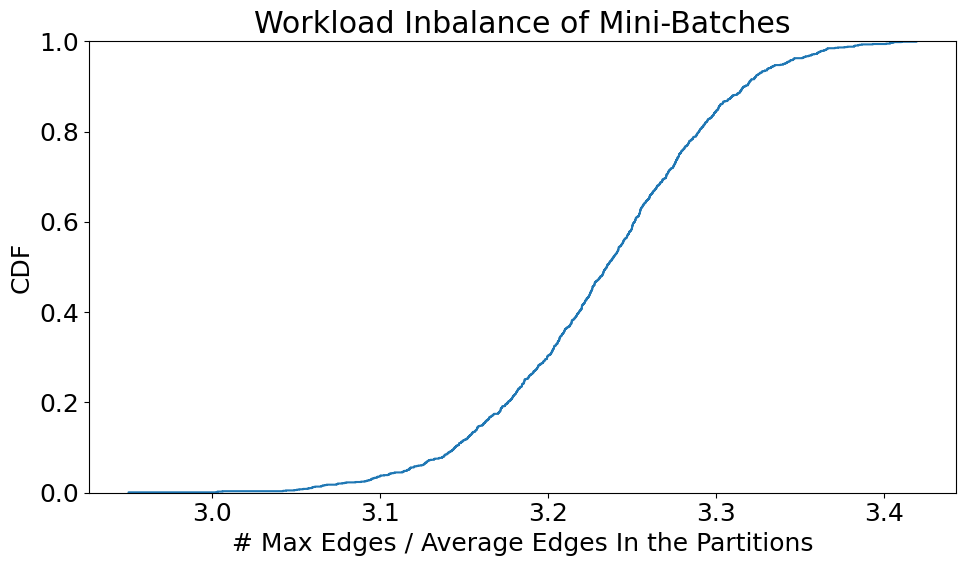

train_idx_workload:  tensor([308709, 314914, 268642, 314914], device='cuda:0') tensor([0.2557, 0.2609, 0.2225, 0.2609], device='cuda:0')
total_edge_workload: tensor([177999596, 162528589, 165744643, 150096256]) tensor([0.2712, 0.2476, 0.2525, 0.2287])
total_cross_edges:   tensor([52455901, 40359459, 25448004, 26940063]) tensor([0.2947, 0.2483, 0.1535, 0.1795])
total_local_edges:   tensor([125543695, 122169130, 140296639, 123156193]) tensor([0.7053, 0.7517, 0.8465, 0.8205])


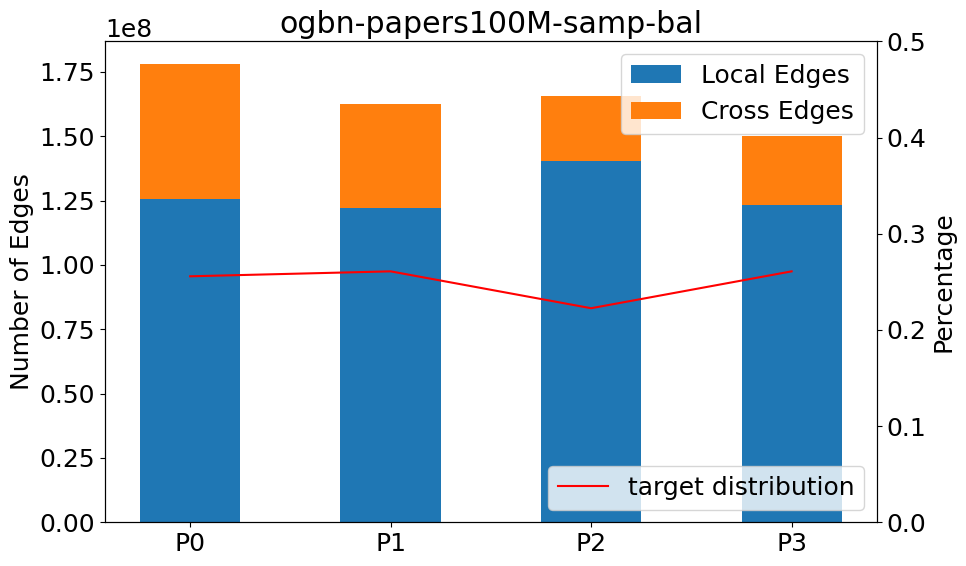

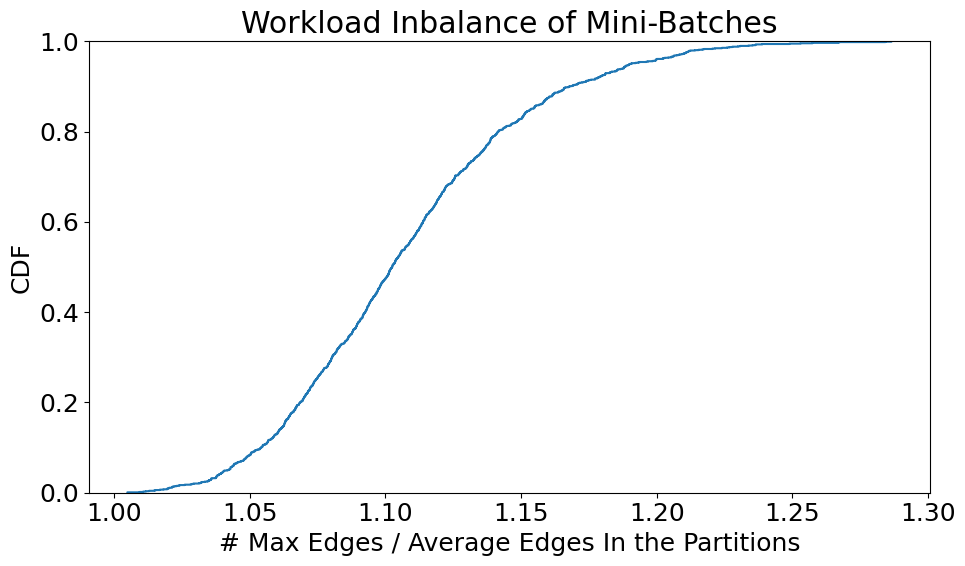

train_idx_workload:  tensor([ 88428, 550633, 194052, 374066], device='cuda:0') tensor([0.0733, 0.4561, 0.1607, 0.3099], device='cuda:0')
total_edge_workload: tensor([139776684, 168809003, 174200701, 173582696]) tensor([0.2130, 0.2572, 0.2654, 0.2645])
total_cross_edges:   tensor([25442641, 14844535, 30611165, 23697076]) tensor([0.1820, 0.0879, 0.1757, 0.1365])
total_local_edges:   tensor([114334043, 153964468, 143589536, 149885620]) tensor([0.8180, 0.9121, 0.8243, 0.8635])


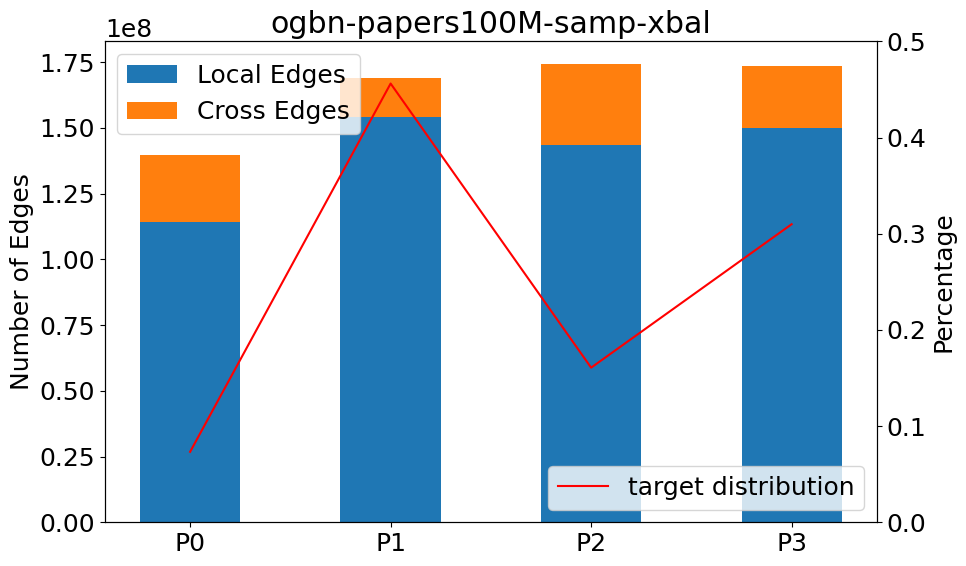

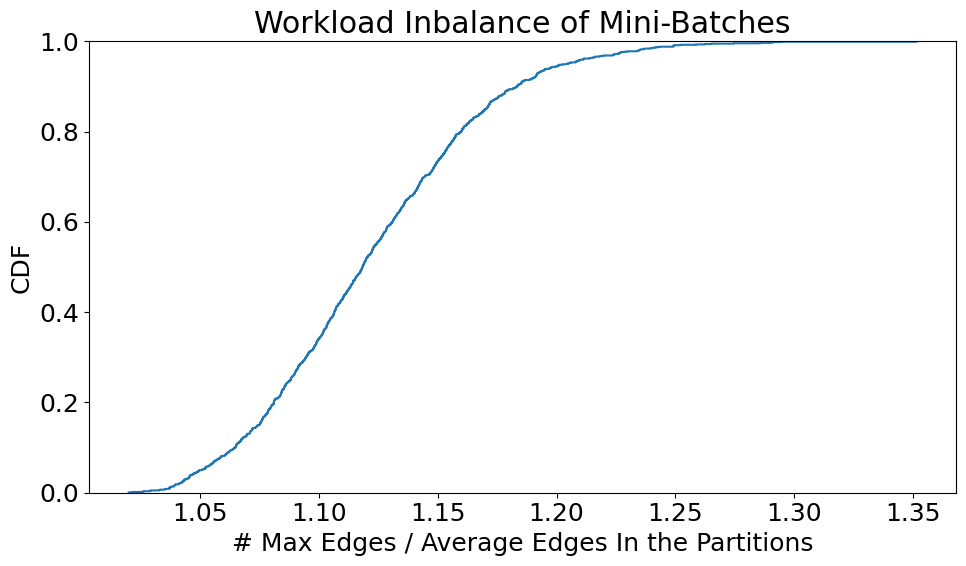

train_idx_workload:  tensor([63548, 63548, 63494, 56188], device='cuda:0') tensor([0.2575, 0.2575, 0.2573, 0.2277], device='cuda:0')
total_edge_workload: tensor([212723140, 188138632, 203019366, 161285904]) tensor([0.2780, 0.2459, 0.2653, 0.2108])
total_cross_edges:   tensor([41535422, 55978964, 34942843, 37041800]) tensor([0.1953, 0.2975, 0.1721, 0.2297])
total_local_edges:   tensor([171187718, 132159668, 168076523, 124244104]) tensor([0.8047, 0.7025, 0.8279, 0.7703])


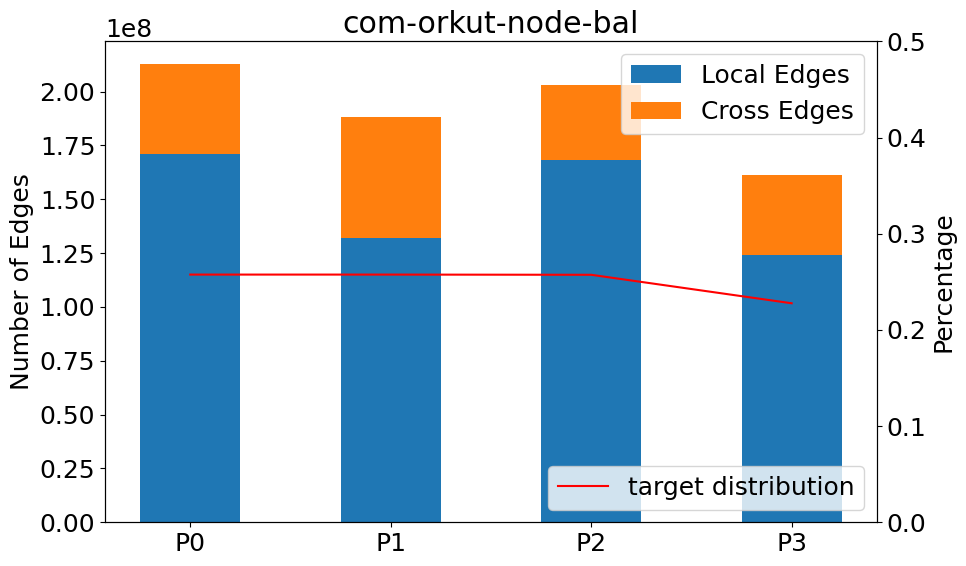

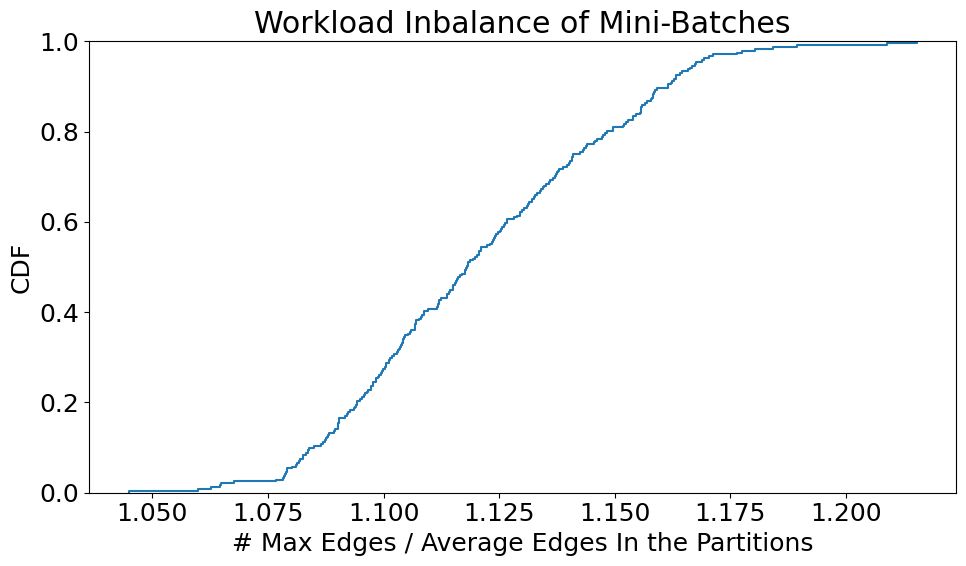

train_idx_workload:  tensor([56403, 63618, 63424, 63333], device='cuda:0') tensor([0.2286, 0.2578, 0.2570, 0.2566], device='cuda:0')
total_edge_workload: tensor([202865581, 177529588, 189089737, 195682136]) tensor([0.2651, 0.2320, 0.2471, 0.2557])
total_cross_edges:   tensor([39182670, 49785595, 37793597, 37806953]) tensor([0.1931, 0.2804, 0.1999, 0.1932])
total_local_edges:   tensor([163682911, 127743993, 151296140, 157875183]) tensor([0.8069, 0.7196, 0.8001, 0.8068])


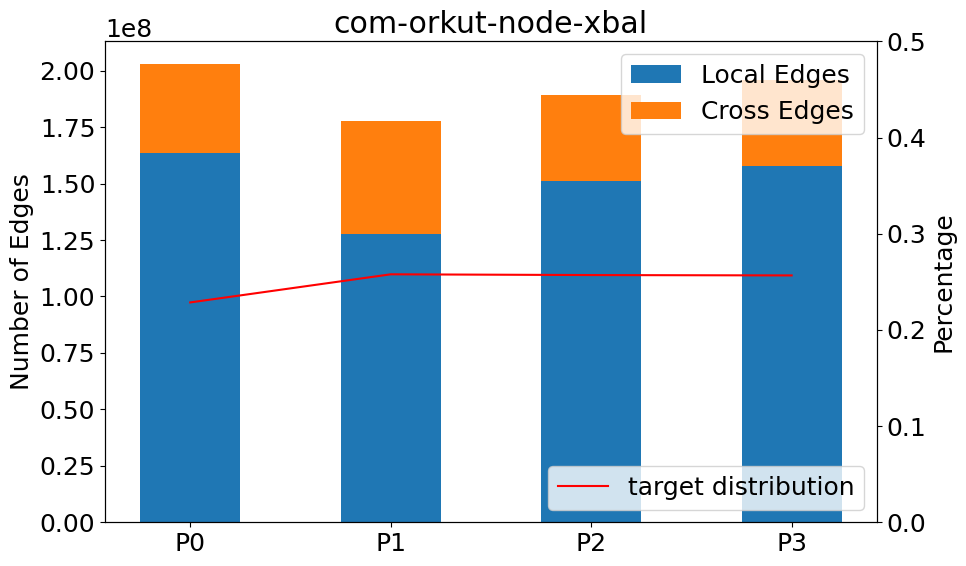

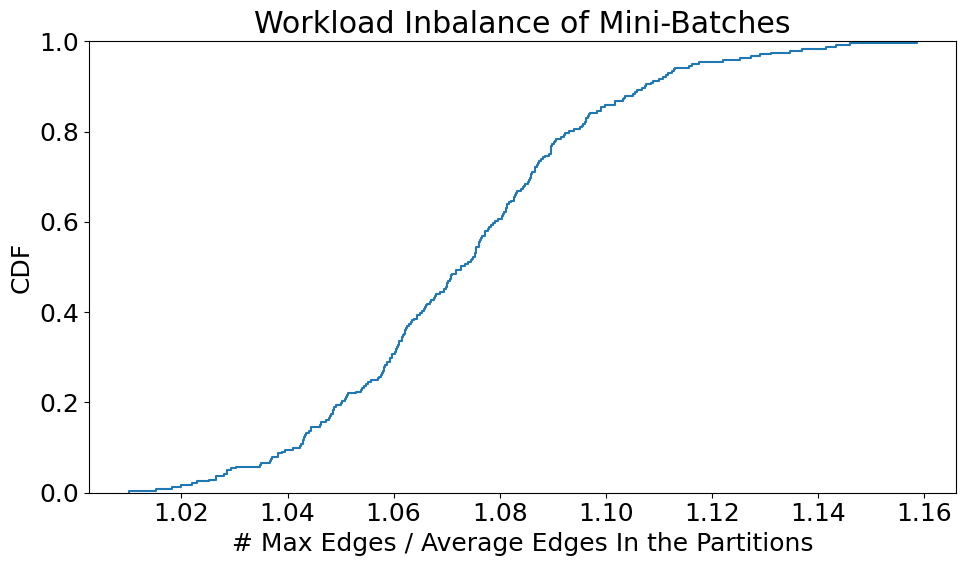

train_idx_workload:  tensor([63167, 55450, 64080, 64081], device='cuda:0') tensor([0.2560, 0.2247, 0.2597, 0.2597], device='cuda:0')
total_edge_workload: tensor([187585664, 158457850, 220703249, 198309897]) tensor([0.2452, 0.2071, 0.2885, 0.2592])
total_cross_edges:   tensor([58382041, 76150543, 59650010, 53508174]) tensor([0.3112, 0.4806, 0.2703, 0.2698])
total_local_edges:   tensor([129203623,  82307307, 161053239, 144801723]) tensor([0.6888, 0.5194, 0.7297, 0.7302])


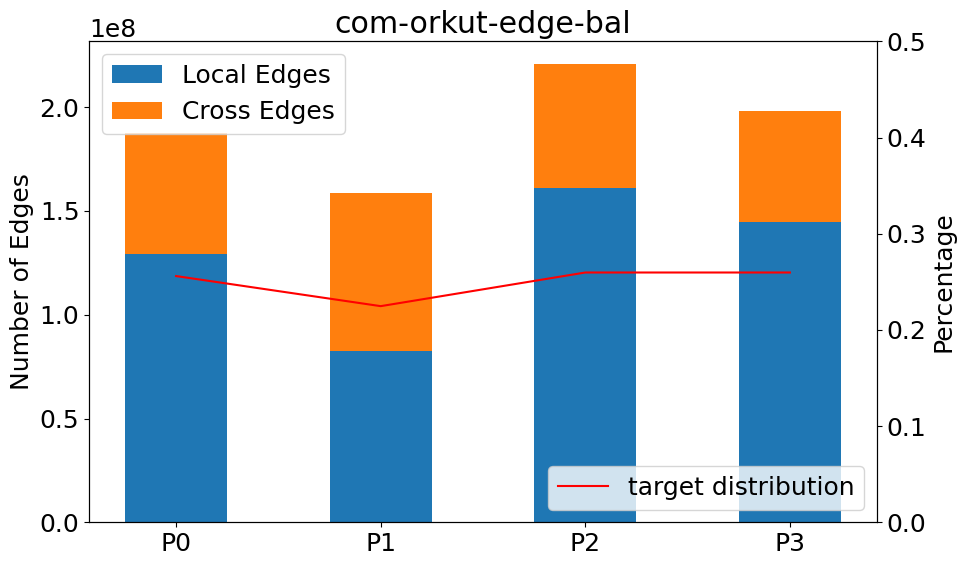

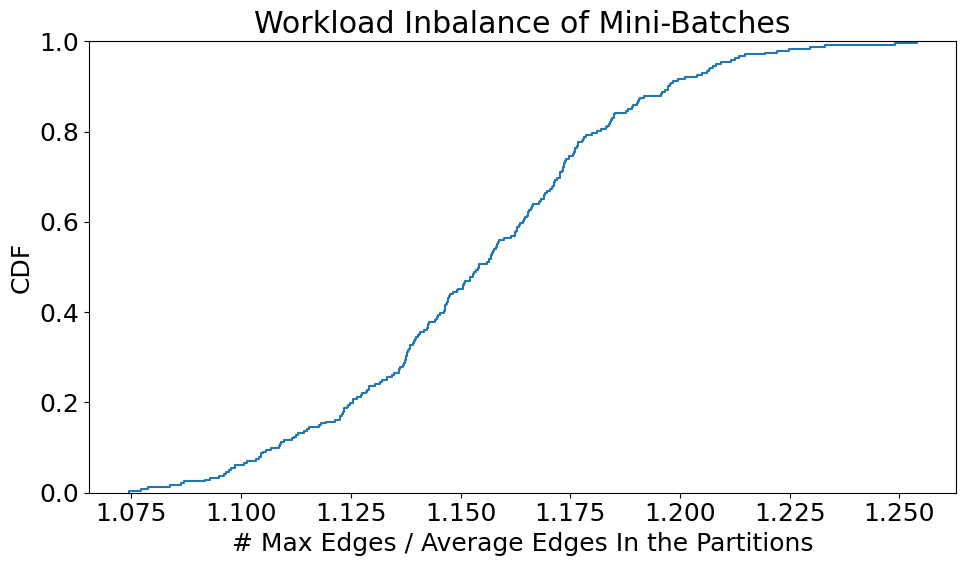

train_idx_workload:  tensor([56377, 62543, 63645, 64213], device='cuda:0') tensor([0.2285, 0.2534, 0.2579, 0.2602], device='cuda:0')
total_edge_workload: tensor([172281794, 177051181, 213603856, 202119829]) tensor([0.2252, 0.2314, 0.2792, 0.2642])
total_cross_edges:   tensor([57872751, 59044356, 63652165, 44079558]) tensor([0.3359, 0.3335, 0.2980, 0.2181])
total_local_edges:   tensor([114409043, 118006825, 149951691, 158040271]) tensor([0.6641, 0.6665, 0.7020, 0.7819])


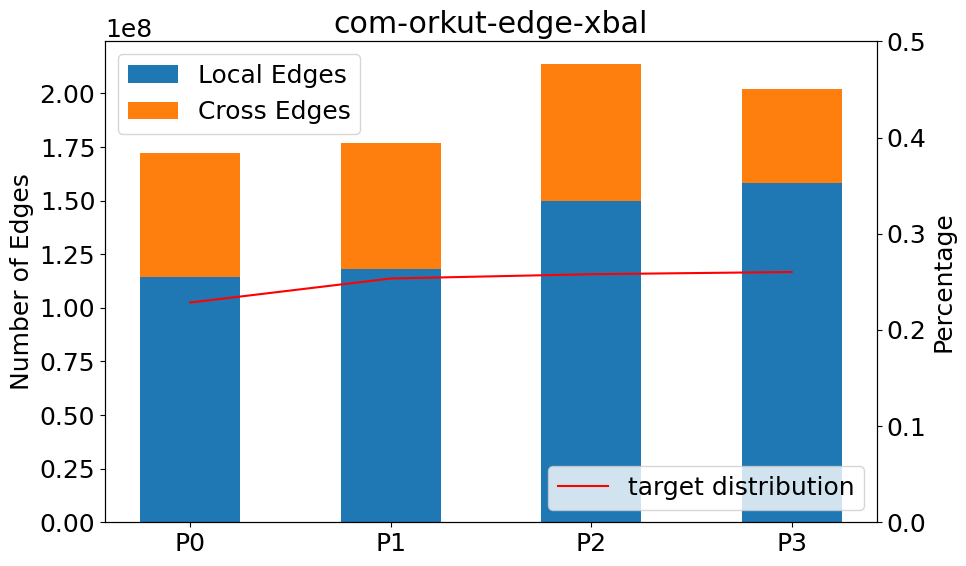

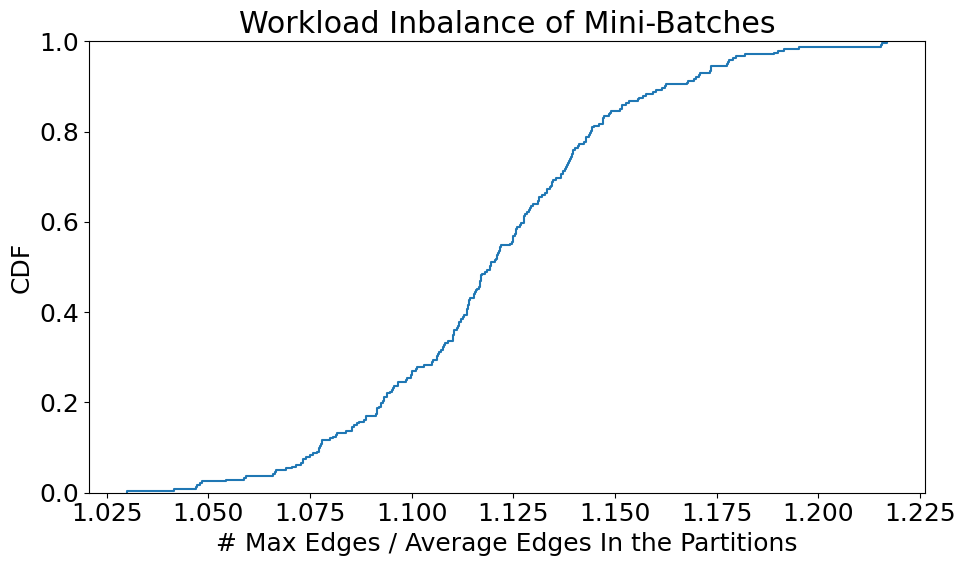

train_idx_workload:  tensor([63548, 63548, 56135, 63547], device='cuda:0') tensor([0.2575, 0.2575, 0.2275, 0.2575], device='cuda:0')
total_edge_workload: tensor([189619132, 194744602, 185112421, 195609272]) tensor([0.2478, 0.2545, 0.2419, 0.2557])
total_cross_edges:   tensor([35609001, 29327195, 42875425, 49997113]) tensor([0.1878, 0.1506, 0.2316, 0.2556])
total_local_edges:   tensor([154010131, 165417407, 142236996, 145612159]) tensor([0.8122, 0.8494, 0.7684, 0.7444])


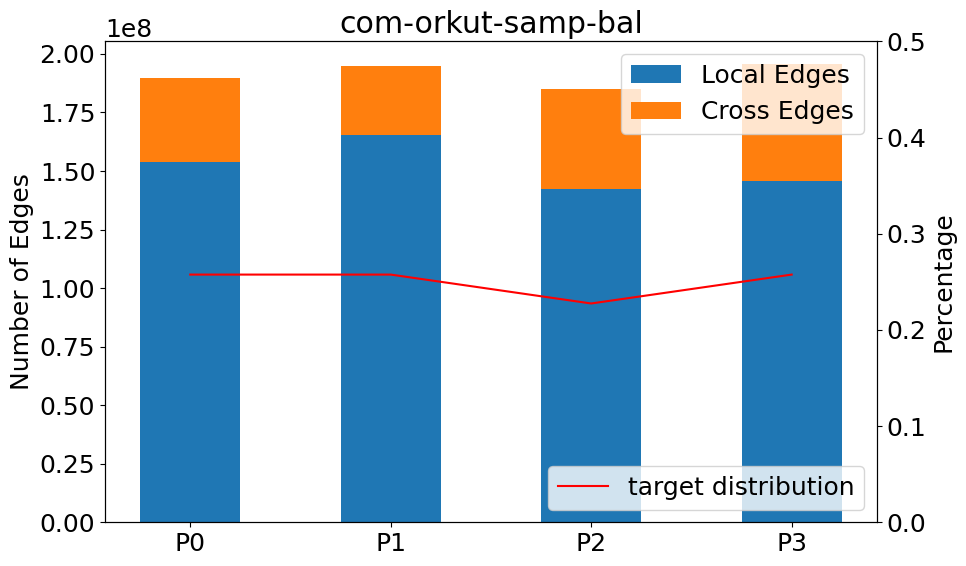

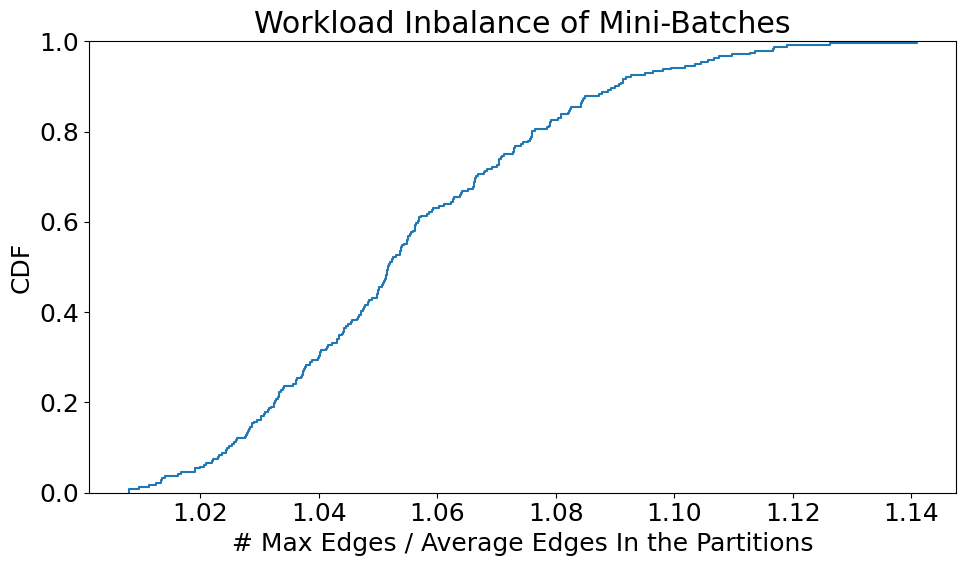

train_idx_workload:  tensor([53799, 64594, 64205, 64180], device='cuda:0') tensor([0.2180, 0.2617, 0.2602, 0.2601], device='cuda:0')
total_edge_workload: tensor([183768188, 192503015, 192615226, 196198998]) tensor([0.2402, 0.2516, 0.2518, 0.2564])
total_cross_edges:   tensor([41106822, 55257679, 35222257, 33495612]) tensor([0.2237, 0.2870, 0.1829, 0.1707])
total_local_edges:   tensor([142661366, 137245336, 157392969, 162703386]) tensor([0.7763, 0.7130, 0.8171, 0.8293])


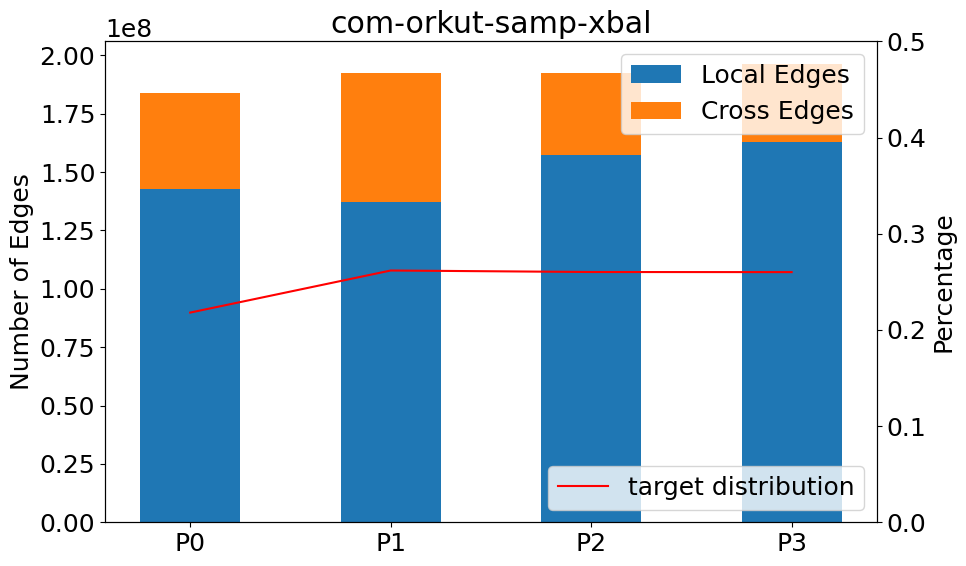

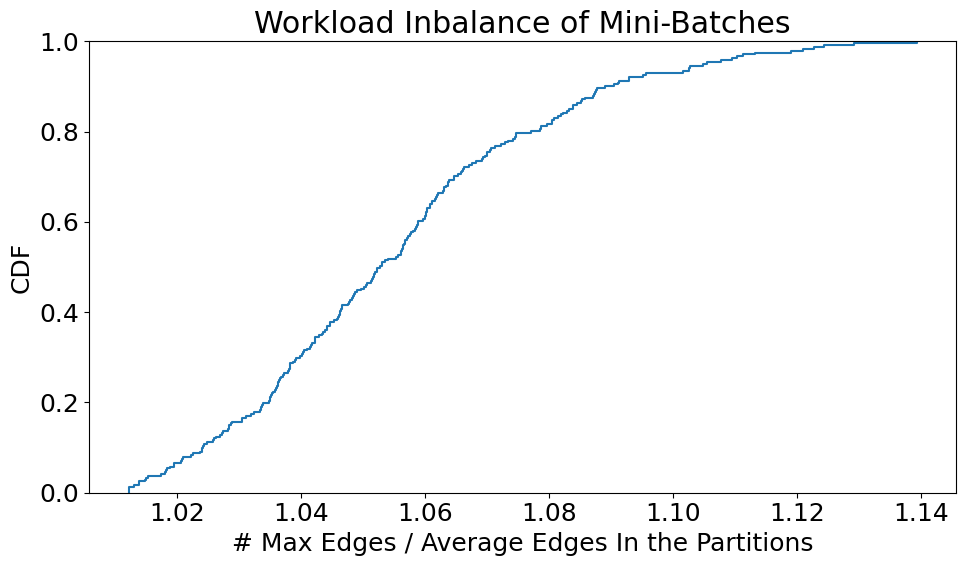

In [7]:
dataset = {
    "ogbn-products":   "/data/juelin/dataset/OGBN/processed",
    "ogbn-papers100M": "/data/juelin/dataset/OGBN/processed",
    "com-orkut": "/data/juelin/dataset/SNAP/",
    "com-friendster": "/data/juelin/dataset/SNAP/"
}

for graph_name, data_dir in dataset.items():
    for is_pruned in [False]:
        for partype in ["node", "edge", "samp"]:
            for bal in ["bal", "xbal"]:
                plot(graph_name, data_dir, is_pruned, partype, bal)